In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
cd drive/My Drive/Mask_detection_Project

/content/drive/My Drive/Mask_detection_Project


In [3]:
base = os.getcwd()
ds_path = os.path.join(base, "mask_ds")

## 데이터셋 설명:
- cor_mask, nomask, incor_mask
- 폴더별 1400장 씩 (총 4200 장)
- 1400 -> train 896, valid 224, test 280


### 데이터 공유링크
https://drive.google.com/drive/folders/1QYrzMsNo5oLGO-sMddC3qDUYvVIxJfcf?usp=sharing

## Mask classifier training (preprocess)


In [4]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(ds_path))
data = []
labels_origin = []

# label_candidates = ['nomask','mask_inc', 'mask_cor']
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# 다 keras 기반 함수들 load_img -> img_to_arrary -> preprocess_input 
	image = load_img(imagePath, target_size=(224, 224)) # resizing
	image = img_to_array(image) # numpy array로 변환 
	image = preprocess_input(image) # compatible 한 전처리를 위해 위의 load_img랑 세트 ,mobilnetv2만을 위한 preprocess class # 픽셀값들이 샘플별로 -1 ~ 1로 스케일링

	# update the data and labels lists, respectively
	data.append(image)
	labels_origin.append(label)
 
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels_origin = np.array(labels_origin)
print(labels_origin)

[INFO] loading images...
['cor_mask' 'cor_mask' 'cor_mask' ... 'incor_mask' 'incor_mask'
 'incor_mask']


In [5]:
# perform one-hot encoding on the labels
lb = LabelEncoder() #sklearn LB vs onehot => int vs float...?
labels = lb.fit_transform(labels_origin)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
(trainX, validX, trainY, validY) = train_test_split(trainX, trainY, test_size=0.20, stratify=trainY, random_state=42)

# construct the training image generator for data augmentation, 다양한 변조이미지들로도 학습
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Mask classifier fine-tuning & training


In [6]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# Change binary to categorical 
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validX, validY),
	validation_steps=len(validX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
84/84 [==============================] - 30s 357ms/step - loss: 0.6468 - accuracy: 0.7292 - val_loss: 0.2175 - val_accuracy: 0.9435
Epoch 2/20
84/84 [==============================] - 29s 351ms/step - loss: 0.2381 - accuracy: 0.9126 - val_loss: 0.1550 - val_accuracy: 0.9583
Epoch 3/20
84/84 [==============================] - 29s 350ms/step - loss: 0.1695 - accuracy: 0.9442 - val_loss: 0.1317 - val_accuracy: 0.9717
Epoch 4/20
84/84 [==============================] - 30s 352ms/step - loss: 0.1394 - accuracy: 0.9483 - val_loss: 0.1175 - val_accuracy: 0.9777
Epoch 5/20
84/84 [==============================] - 29s 349ms/step - loss: 0.1335 - accuracy: 0.9561 - val_loss: 0.1121 - val_accuracy: 0.9792
Epoch 6/20
84/84 [==============================] - 29s 350ms/step - loss: 0.1135 - accuracy: 0.9617 - val_loss: 0.1026 - val_accuracy: 0.9792
Epoch 7/20
84/84 [==============================] - 29s 350ms/step - loss: 0.0992 - accuracy

## Mask classifier 성능 평가

In [8]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

    cor_mask       0.99      0.98      0.99       280
  incor_mask       0.98      0.99      0.99       280
      nomask       0.99      1.00      0.99       280

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840

[INFO] saving mask detector model...


NameError: ignored

In [11]:
model.save("model", save_format="h5")

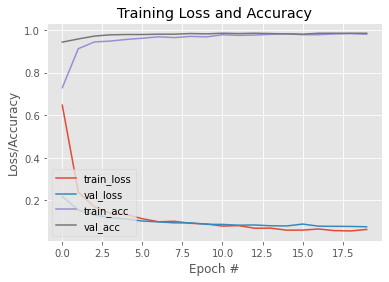

In [13]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")